# Example neural network on 1D data

In [1]:

# Import dependencies

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Set random seed for reproducibility
_ = torch.manual_seed(7)

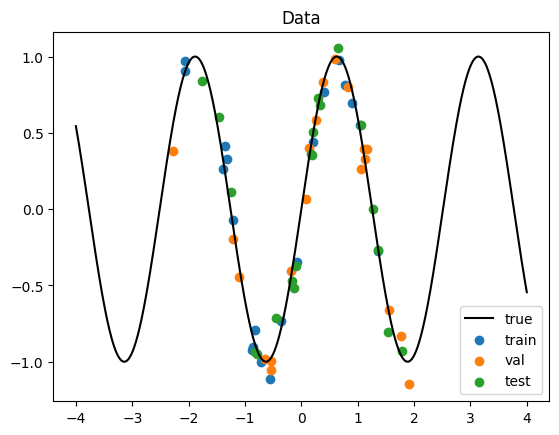

In [2]:
# Generate some data

# Data parameters
n_train, n_val, n_test = 20, 20, 20
a = 2.5  # Frequency of the first sine wave
b = 7.0  # Frequency of the second sine wave
c = 1.0  # Mixing parameter, between 0 and 1
noise = 0.1  # Noise level, greater than 0
train_x_scale = 1.0  # Scale x range for the train data
val_x_scale = 1.0  # Scale x range for the val data
test_x_scale = 1.1  # Scale x range for the test data

# Define true function
def f(x):
    return c * torch.sin(a * x) + (1 - c) * torch.sin(b * x)

# Define function to generate data with noise
def generate_xy(n, noise=0.1, x_scale=1.0):
    x = torch.randn(n) * x_scale
    y = f(x) + torch.randn(n) * noise
    return x, y

# Generate training, validation and test data
x = torch.linspace(-4, 4, 1000)
x_train, y_train = generate_xy(n_train)
x_val, y_val = generate_xy(n_val)
x_test, y_test = generate_xy(n_test, noise, test_x_scale)


# Define function for plotting the data
def plot(x_pred=None, y_pred=None):
    plt.figure()
    plt.title("Data")
    plt.plot(x, f(x), color="k", label='true')
    plt.scatter(x_train, y_train, label='train')
    plt.scatter(x_val, y_val, label='val')
    plt.scatter(x_test, y_test, label='test')
    # plt.xlim(-4, 4)
    if x_pred is not None and y_pred is not None:
        plt.plot(x_pred, y_pred, color="r", label='pred')
    plt.legend()
    plt.show()

# Plot the data
plot()

In [3]:
# Define the model

class NeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_size=10, act=torch.relu):
        super(NeuralNetwork, self).__init__()
        self.hidden = torch.nn.Linear(1, hidden_size)
        self.act = act
        self.output = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.hidden(x)  # hidden layer
        x = self.act(x)  # activation function
        x = self.output(x)  # output layer
        return x

NeuralNetwork(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)


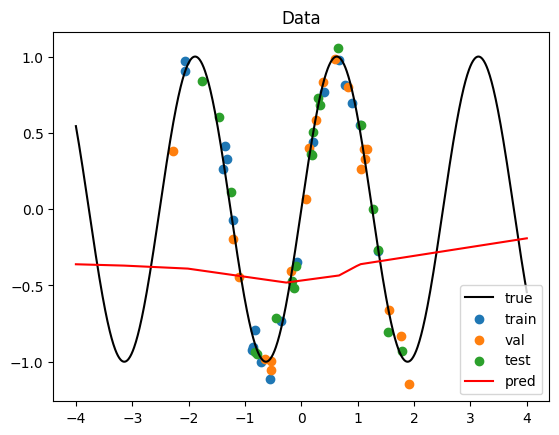

In [4]:
# Predict with an untrained model

# Instantiate untrained model
model = NeuralNetwork()

# Print the model
print(model)

# Predict with the untrained model
y_pred = model(x.unsqueeze(1)).squeeze().detach()

# Plot the data and the predictions
plot(x, y_pred)

In [5]:
# Define training loop

def train(model, x_train, y_train, x_val, y_val, epochs=1000, lr=0.01, weight_decay=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()  # Loss function
    records = []
    for epoch in range(epochs + 1):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train.unsqueeze(1)).squeeze()
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        records.append({"epoch": epoch, "train_loss": loss.item()})
        if epoch == 0 or epoch % 100 == 0:
            model.eval()
            y_val_pred = model(x_val.unsqueeze(1)).squeeze()
            val_loss = criterion(y_val_pred, y_val)
            records.append({"epoch": epoch, "val_loss": loss.item()})
            print(f"Epoch {epoch:5d} train_loss: {loss.item():.4f} val_loss: {val_loss.item():.4f}")
    return pd.DataFrame(records)


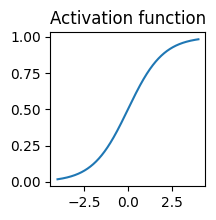

Epoch     0 train_loss: 1.2032 val_loss: 0.7861
Epoch   100 train_loss: 0.4393 val_loss: 0.5173
Epoch   200 train_loss: 0.2740 val_loss: 0.4289
Epoch   300 train_loss: 0.0866 val_loss: 0.3237
Epoch   400 train_loss: 0.0417 val_loss: 0.2525
Epoch   500 train_loss: 0.0305 val_loss: 0.1935
Epoch   600 train_loss: 0.0236 val_loss: 0.1429
Epoch   700 train_loss: 0.0180 val_loss: 0.1016
Epoch   800 train_loss: 0.0138 val_loss: 0.0717
Epoch   900 train_loss: 0.0107 val_loss: 0.0522
Epoch  1000 train_loss: 0.0084 val_loss: 0.0404


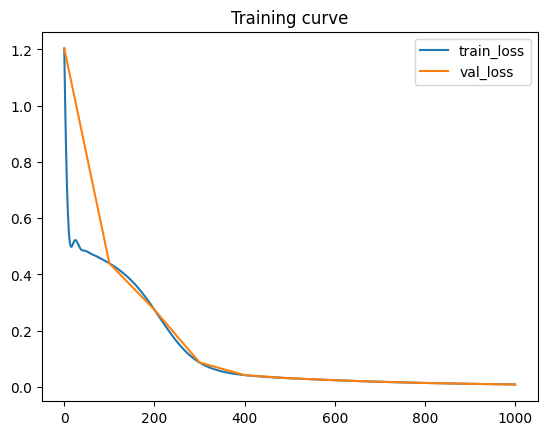

In [6]:
# Train a model

# Model and training parameters
hidden_size = 10
activation_function = torch.sigmoid  # torch.sigmoid, torch.relu, torch.nn.SiLU()
epochs = 1000
learning_rate = 0.01
weight_decay = 0.0  # L2 penalty, between 0.0 and 0.1

# Plot activation function
plt.figure(figsize=(2, 2))
plt.title("Activation function")
plt.plot(x, activation_function(x))
plt.show()

# Instantiate and train a new model
model = NeuralNetwork(hidden_size, activation_function)
log = train(model, x_train, y_train, x_val, y_val, epochs, learning_rate, weight_decay)

# Plot the training and validation losses
plt.figure()
plt.title("Training curve")
for k in ["train_loss", "val_loss"]:
    tmp = log[["epoch", k]].dropna()
    plt.plot(tmp["epoch"], tmp[k], label=k)
plt.legend()
plt.show()

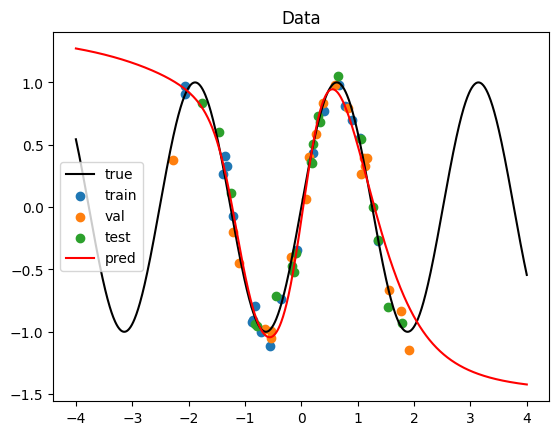

In [7]:
# Predict with trained model

y_pred = model(x.unsqueeze(1)).squeeze().detach()

plot(x, y_pred)

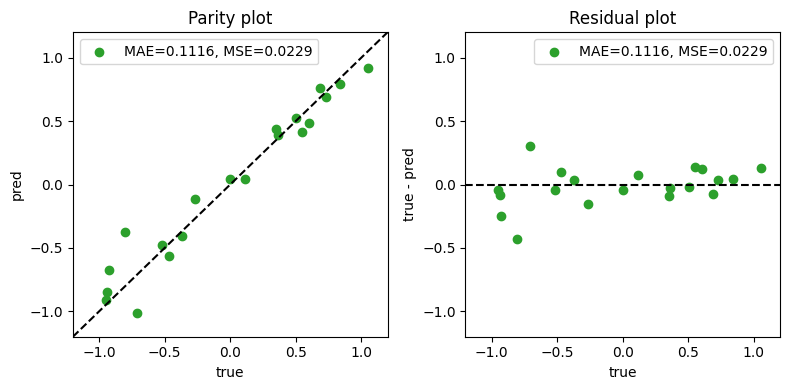

In [8]:
# Evaluate the model on the test set

y_test_pred = model(x_test.unsqueeze(1)).squeeze().detach()

# Compute the mean absolute error on the test data
mae = torch.mean(torch.abs(y_test - y_test_pred))
# Compute the mean squared error on the test data
mse = torch.mean(torch.square(y_test - y_test_pred))

lim = (-1.2, 1.2)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Parity plot")
plt.scatter(y_test, y_test_pred, color="C2", label=f"MAE={mae:.4f}, MSE={mse:.4f}")
plt.plot(lim, lim, 'k--')
plt.xlabel("true"); plt.ylabel("pred")
plt.xlim(lim); plt.ylim(lim)
plt.legend()
plt.subplot(122)
plt.title("Residual plot")
plt.scatter(y_test, y_test - y_test_pred, color="C2", label=f"MAE={mae:.4f}, MSE={mse:.4f}")
plt.plot(lim, [0, 0], 'k--')
plt.xlabel("true"); plt.ylabel("true - pred")
plt.xlim(lim); plt.ylim(lim)
plt.legend()
plt.tight_layout()
plt.show()

## Exercises

* Read and understand the code. Especially the model and training procedure. Refer to the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).
* Try to change the data parameters to make the task harder. For example try `c=0.5`.
* Then try to change the model and training parameters to improve the predictions. For example increase the size of the hidden layer and the amount of training data.
* Try a different activation function. 
* Add another hidden layer to the model.
* Make your own experiments!

